In [46]:
from zipfile import ZipFile

import re

import random

import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from gensim import corpora
from gensim import similarities
from gensim.models import *
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt
from matplotlib import style

import numpy as np

import pandas as pd

from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer, LabelEncoder

/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.7/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.g

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Загрузка всех файлов из zip-архива
def load_data(zip_name):
    documents_list = []
    with ZipFile(zip_name, 'r') as zip:
        zip.extractall()
        listofiles = zip.namelist()
    for element in listofiles:
        text = open(element, 'r', encoding = 'utf-8').read()
        documents_list.append([text])
    print("Всего текстов: ", len(documents_list))
    return documents_list

In [ ]:
#Предобработка текста
def preprocess_data(documents_list):
    #Стоп-слова
    stop_words = stopwords.words("russian")
    #Пунктуация
    punct = re.compile("[^\w\s]")
    processed_documents = []
    for doc in documents_list:
      for text in doc:
        #Избавляемся от пунктуации
        file_without_punct = re.sub(punct, "", text)
        #Приводим к нижнему регистру
        file_without_punct = file_without_punct.lower()
        #Токенизируем
        info_tokenized = word_tokenize(file_without_punct)
        #Лемматизируем
        info_lemmatized = []
        for token in info_tokenized:
            lemma = morph.parse(token)[0]
            lemma = lemma.normal_form
            info_lemmatized.append(lemma)
        #Фильтруем от стоп-слов
        info_filtered = []
        for lemma in info_lemmatized:
            if lemma not in stop_words:
                info_filtered.append(lemma)
        processed_documents.append(info_filtered)
    return processed_documents

In [ ]:
#Проводим предобработку
nltk.download('stopwords')
nltk.download('punkt')
document_list = load_data("Тексты.zip")
processed_documents = preprocess_data(document_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Всего текстов:  4


In [58]:
#Создаём словарь, содержащий количество раз, которое слово появляется в обучающем наборе.
dictionary = corpora.Dictionary(processed_documents)
print('Original: {}'.format(dictionary))
#Берём только те слова, которые встречаются минимум в 2 документах и более, чем в 0.9 всех документоа.
dictionary.filter_extremes(no_below = 1, no_above = 0.9, keep_n=None)
print('Filtered: {}'.format(dictionary))

corpus = [dictionary.doc2bow(text) for text in processed_documents]

Original: Dictionary(1418 unique tokens: ['1', '10', '11', '14', '17']...)
Filtered: Dictionary(249 unique tokens: ['1', '14', '26', 'академик', 'академия']...)


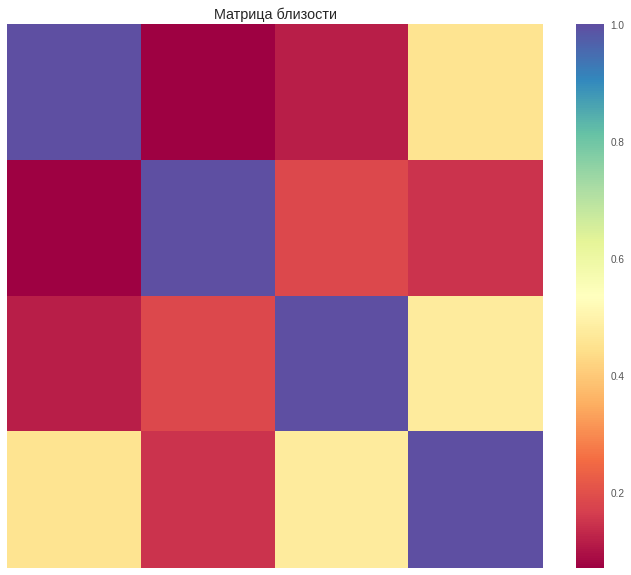

In [61]:
#Определим семантическую близость документов
style.use('ggplot')

# tf-idf векторах
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# вычисление сходства по косинусной мере на tf-idf векторах
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [66]:
#Модель ЛСА - Латентный Семантический анализ
lsi = lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=20, chunksize=50)

In [71]:
#Можно посмотреть слова, принадлежащие выделенным темам.
lsi.show_topics(num_words=10, formatted=False)

[(0,
  [('павлов', 0.5477573862448788),
   ('который', 0.2651368566970381),
   ('п', 0.2280761809331171),
   ('физиология', 0.21025782557390182),
   ('система', 0.20640330155241804),
   ('теория', 0.19259581597164965),
   ('свой', 0.16322812186970115),
   ('академия', 0.14668222556738075),
   ('анохин', 0.14527971509877075),
   ('работа', 0.1423197458608601)]),
 (1,
  [('павлов', -0.5641419669702884),
   ('система', 0.37857930532019546),
   ('теория', 0.29185697618759565),
   ('нейрон', 0.2047643158354878),
   ('новый', 0.16349907865305566),
   ('который', 0.1583512448908707),
   ('академия', -0.15134442814150267),
   ('анохин', 0.14900582332713125),
   ('это', 0.14887217478637832),
   ('человек', 0.11704582078396521)]),
 (2,
  [('п', 0.3274833746428401),
   ('анохин', 0.3272560459196533),
   ('физиология', 0.24222190634947977),
   ('который', -0.2333905232161874),
   ('павлов', -0.21835347683967582),
   ('свой', -0.19564079635175213),
   ('нейрон', -0.18354669648842764),
   ('медицинс

In [68]:
#Обучаем модель LDA
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 31.3 ms, sys: 345 µs, total: 31.6 ms
Wall time: 34 ms


In [72]:
lda.show_topics(num_topics=5, num_words=10, formatted=False)

[(19,
  [('павлов', 0.059361815),
   ('академия', 0.017635755),
   ('свой', 0.01404603),
   ('физиология', 0.013426649),
   ('который', 0.013312076),
   ('жизнь', 0.012002783),
   ('п', 0.01061699),
   ('работать', 0.010231183),
   ('стать', 0.009962525),
   ('университет', 0.009583929)]),
 (13,
  [('система', 0.034799248),
   ('теория', 0.028381912),
   ('который', 0.025415163),
   ('нейрон', 0.01830217),
   ('новый', 0.01592674),
   ('это', 0.014814349),
   ('человек', 0.013288808),
   ('организм', 0.012977666),
   ('поведение', 0.012217361),
   ('мочь', 0.012166161)]),
 (16,
  [('система', 0.024634248),
   ('теория', 0.0210252),
   ('п', 0.01821711),
   ('анохин', 0.017271236),
   ('физиология', 0.015298015),
   ('который', 0.014535019),
   ('работа', 0.012920741),
   ('физиологический', 0.0112223495),
   ('это', 0.011037032),
   ('кафедра', 0.01089984)]),
 (5,
  [('система', 0.04164909),
   ('теория', 0.035779297),
   ('который', 0.027978225),
   ('анохин', 0.024957575),
   ('это',

In [73]:
#Визуализация LDA
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 270 ms, sys: 36.2 ms, total: 306 ms
Wall time: 4.77 s
